In [2]:
import ee
import geemap
import pprint
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
from pprint import pprint
import copy
import string
from io import StringIO
from pandas.compat import StringIO
from pandas import DataFrame
from celluloid import Camera
import pylandstats as pls

In [3]:
ee.Initialize()

## Parameters (INPUT)

In [4]:
out_dir = os.path.join(os.path.expanduser('~'), 'gee/Japan_mapping/results/analysis/')

## Load maps and prefecures

In [5]:
# Load rice maps
tambo1519_path = 'users/luiscartor/tambo_1519_filtered'
tambo1519 = geemap.ee.Image(tambo1519_path)
tambo1014_path = 'users/luiscartor/tambo_1014_filtered'
tambo1014 = geemap.ee.Image(tambo1014_path)
tambo0509_path = 'users/luiscartor/tambo_0509_filtered'
tambo0509 = geemap.ee.Image(tambo0509_path)
tambo0004_path = 'users/luiscartor/tambo_0004_filtered'
tambo0004 = geemap.ee.Image(tambo0004_path)
tambo9599_path = 'users/luiscartor/tambo_9599_filtered'
tambo9599 = geemap.ee.Image(tambo9599_path)
tambo9094_path = 'users/luiscartor/tambo_9094_filtered'
tambo9094 = geemap.ee.Image(tambo9094_path)
tambo8589_path = 'users/luiscartor/tambo_8589_filtered'
tambo8589 = geemap.ee.Image(tambo8589_path)

# Load prefectures and Japan shapefiles (from GEE account)
japan_shp = 'users/luiscartor/japan_gadm0'
japan = geemap.ee.FeatureCollection(japan_shp)

prefs_shp = 'users/luiscartor/japan_gadm1_noOKINAWA'
prefs = geemap.ee.FeatureCollection(prefs_shp)

# List of prefectures transplanting START DOY: We extract from here the used prefectures
transplant_startdates_table = '../Japan_mapping/data/transplanting_startdates.csv'
transplant_startdates = pd.read_csv(transplant_startdates_table, sep=",")

## Visualize maps

In [6]:
Map = geemap.Map(center=[38,138], zoom=6)
Map.add_basemap('HYBRID')
Map

Map(center=[38, 138], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

In [7]:
Map.addLayer(prefs, {}, 'Prefectures')
Map.addLayer(tambo8589,{min: 0, max: 1},'tambo8589')

In [95]:
#pprint(transplant_startdates.Prefecture)
#data = pd.DataFrame(transplant_startdates.Prefecture)

## Extract rice area to table

In [132]:
periods_dict = {'8589': tambo8589,
              '9094': tambo9094,
              '9599': tambo9599,
              '0004': tambo0004,
              '0509': tambo0509,
              '1014': tambo1014,
               '1519': tambo1519}


data = pd.DataFrame(transplant_startdates.Prefecture)
# Loop through periods
for period in periods_dict.values():
    #period = tambo8589

    periodname = list(periods_dict.keys())[list(periods_dict.values()).index(period)]
    filename = os.path.join(out_dir, periodname + '_ricestats.csv')  



    # Add reducer output to the Features in the collection.
    sums = period.reduceRegions(**{
      'collection': prefs,
      'reducer': ee.Reducer.sum(),
      'scale': 30,
    })

    values = sums.reduceColumns(ee.Reducer.toList(2), ['NAME_1','sum']).values().get(0)
    values_df = pd.DataFrame(values.getInfo(),columns=['Prefecture','Sum'])
    #pprint(values_df)

    data = data.merge(values_df, on='Prefecture', how='left')

# Changes column names
data.columns = ['Prefecture', '8585','9094','9599','0004','0509','1014','1519']

pprint(data)


   Prefecture     8585     9094     9599     0004     0509     1014     1519
0    Hokkaido  1889830  2258053  1969176  1662737  1470572  1322012  1160669
1      Aomori   826754   782298   757940   623498   562672   565235   530364
2       Iwate   721346   671388   649910   587051   575360   513986   544502
3      Miyagi  1144595  1068532  1155974  1049124   985740   871179   945727
4       Akita  1464030  1394416  1313720  1230608  1166900  1176633  1096792
5    Yamagata   929342   914767   881482   739442   689685   695832   696625
6   Fukushima   817636   860351   897745   773530   763336   664047   644695
7     Ibaraki  1169399  1016892   959514  1006668   990912   993400   883702
8     Tochigi   852874   784553   670574   733367   707700   585932   628785
9       Gunma   258013   265479   164104   157342   134271   121886   146971
10    Saitama   548219   414243   354568   400328   388649   328220   370854
11      Chiba   770764   740520   727331   691663   699024   679830   637013

### Process table

In [159]:
# Converts pixel count to km2 (each pixel is 900m2)
areatable = data.copy()
areatable[areatable.columns[1:8]] = areatable[areatable.columns[1:8]].multiply(900/1000)
#areatable

# Adds row with totals
areatable = areatable.append(areatable.sum(numeric_only=True), ignore_index=True)
# Rename Japan total row
areatable.loc[areatable.index[-1],'Prefecture'] = 'AllJapan'
areatable

# Save table
areatable.to_csv(out_dir + 'riceareabyprefecture.csv', index = False)

## Visualize area results

In [166]:
# We first transfrom the table by using .melt()
plottable = pd.melt(areatable, id_vars=['Prefecture'], value_vars=['8585','9094','9599','0004','0509','1014','1519'])
plottable = plottable.rename(columns={'variable':'period','value': 'area'})

# Converts period column into factor
plottable['period'] = plottable['period'].astype('category')

plottable.head(10)

,Prefecture,period,area
0,Hokkaido,8585,1700847.0
1,Aomori,8585,744078.6
2,Iwate,8585,649211.4
3,Miyagi,8585,1030135.5
4,Akita,8585,1317627.0
5,Yamagata,8585,836407.8
6,Fukushima,8585,735872.4
7,Ibaraki,8585,1052459.1
8,Tochigi,8585,767586.6
9,Gunma,8585,232211.7


### Whole Japan

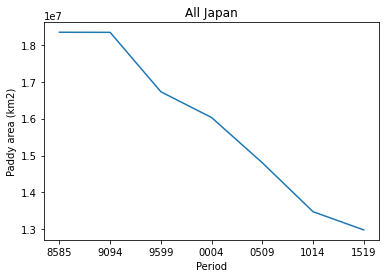

In [184]:
# Plot area change for Japan
df = plottable[plottable.Prefecture == 'AllJapan']

plt.plot(df.period,df.area)
plt.xlabel('Period')
plt.ylabel('Paddy area (km2)')
plt.title('All Japan')
plt.savefig(out_dir + 'alljapan_ricechange.jpg')
plt.show()



### Prefectural changes

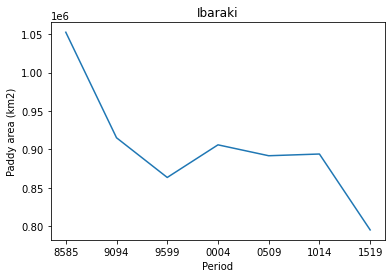

In [171]:
# Select prefecture to plot
pref = 'Ibaraki'

df = plottable[plottable.Prefecture == pref]

plt.plot(df.period,df.area)
plt.xlabel('Period')
plt.ylabel('Paddy area (km2)')
plt.title(pref);
plt.show()





MovieWriter imagemagick unavailable; using Pillow instead.


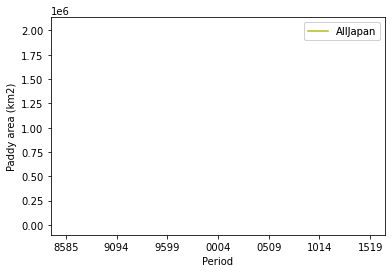

In [185]:
# Create animation plotting all prefectures
df = plottable[plottable.Prefecture != 'AllJapan']

fig = plt.figure()
camera = Camera(fig)

#fig, ax = plt.subplots(figsize=(9,6)) # empty fig
for pref in plottable.Prefecture:
    t = plt.plot(df.loc[df['Prefecture']==pref,'period'],df.loc[df['Prefecture']==pref,'area'])
    plt.xlabel('Period')
    plt.ylabel('Paddy area (km2)')
    plt.legend(t, [f'{pref}'])
    camera.snap()
    
animation = camera.animate()
animation_output = os.path.join(out_dir, 'riceareachange_prefectures.gif')
animation.save(animation_output, writer = 'imagemagick', fps=2) #frames per second modifies speed of animation

# Fragmentation analysis

In [ ]:
tambolands8589 = pls.Landscape('/Users/luis/Documents/research/jsps/ricemapping/ricemaps/tambo_8589_filtered.tif') #loaded from disk

patchmetrics8589 = tambolands8589.compute_patch_metrics_df()
patchmetrics8589